## Data

Data downloaded from Kaggle's Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

**Note:** The lower our RMSLE, the better!

## Features

Kaggle provides a data dictionary detailing all of the features of the dataset. Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import *

In [2]:
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=['saledate'])

<AxesSubplot:ylabel='Frequency'>

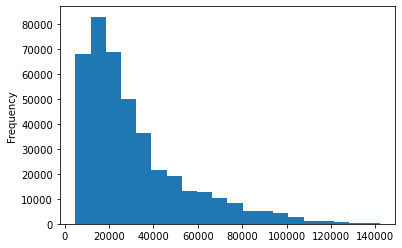

In [3]:
df.SalePrice.plot.hist(bins=20)

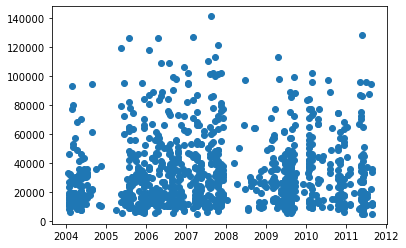

In [4]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

In [5]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [6]:
df.sort_values(by=['saledate'], inplace=True, ascending=True)
dftemp = df.copy()

## Adding Seperated Year, Month, Day, DayOfWeek & DayOfYear to out dftemp

In [7]:
dftemp['saleYear'] = dftemp.saledate.dt.year
dftemp['saleMonth'] = dftemp.saledate.dt.month
dftemp['saleDay'] = dftemp.saledate.dt.day
dftemp['saleDayOfWeek'] = dftemp.saledate.dt.dayofweek
dftemp['saleDayOfYear'] = dftemp.saledate.dt.dayofyear
dftemp.drop('saledate', inplace=True, axis=1)

## Modelling

In [8]:
dftemp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [9]:
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

#### Turning objects into category

In [10]:
for column, content in dftemp.items():
    if pd.api.types.is_string_dtype(content):
        dftemp[column] = content.astype('category').cat.as_ordered()
        
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [11]:
dftemp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [12]:
# Fill the empty numeric values with the median
for column, content in dftemp.items():
    if pd.api.types.is_numeric_dtype(content):
        dftemp[column+'_is_missing'] = pd.isnull(content)
        dftemp[column] = content.fillna(content.median())

In [13]:
# Fill the empty categorical values
for column, content in dftemp.items():
    if not pd.api.types.is_numeric_dtype(content):
        dftemp[column+'_is_missing'] = pd.isnull(content)
        dftemp[column] = pd.Categorical(content).codes + 1

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16488\621391400.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dftemp[column+'_is_missing'] = pd.isnull(content)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16488\621391400.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dftemp[column+'_is_missing'] = pd.isnull(content)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_16488\621391400.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [14]:
dftemp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [15]:
dftemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 114 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(57), float64(3), int16(4), int64(10), int8(40)
memory usage: 85.4 MB


In [16]:
dfval = dftemp[dftemp.saleYear >= 2012]
dftrain = dftemp[dftemp.saleYear < 2012]

len(dfval), len(dftrain)

(11573, 401125)

In [17]:
X_train, y_train = dftrain.drop('SalePrice', axis=1), dftrain.SalePrice
X_valid, y_valid = dfval.drop('SalePrice', axis=1), dfval.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 113), (401125,), (11573, 113), (11573,))

In [18]:
# Create RMSLE evaluation function 

def rmsle(y_test, y_preds):
    '''
    Calculates root mean squared log error between y_true
    and y_preds
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function for eval

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE':mean_absolute_error(y_train, train_preds),
              'Valid MAE': mean_absolute_error(y_valid, val_preds),
              'Training RMSLE': rmsle(y_train, train_preds),
              'Valid RMSLE': rmsle(y_valid, val_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Valid R^2': r2_score(y_valid, val_preds)
             }
    return scores


In [19]:
model = RandomForestRegressor(n_jobs=-1, random_state=69, max_samples=40000)
model.fit(X_train, y_train)

RandomForestRegressor(max_samples=40000, n_jobs=-1, random_state=69)

In [20]:
show_scores(model)

{'Training MAE': 4485.246138410719,
 'Valid MAE': 6427.475961289208,
 'Training RMSLE': 0.213708196260983,
 'Valid RMSLE': 0.2659849978263654,
 'Training R^2': 0.9066899511304157,
 'Valid R^2': 0.8634666574886682}

## Hyperparameter tuning
##### **NOTE**: These were found after 100 iterations of `RandomizedSearchCV`

* n_estimators=40,
* min_samples_leaf=1,
* min_samples_split=14,
* max_features=0.5,
* n_jobs=-1,
* max_samples=None,
* random_state=42

In [21]:
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [22]:
show_scores(ideal_model)

{'Training MAE': 2963.2234267744852,
 'Valid MAE': 5969.52640966996,
 'Training RMSLE': 0.14500362776744555,
 'Valid RMSLE': 0.24695677006515737,
 'Training R^2': 0.9584902355726693,
 'Valid R^2': 0.881317601350001}

## Making predictions on the test data

In [23]:
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv", low_memory=False, parse_dates=['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [24]:
def preprocess_data(df):
    """
    Performs transformations on DataFrame and 
    returns transformed DataFrame.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
    
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [25]:
preprocess_data(df_test)

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


In [26]:
test_preds = ideal_model.predict(df_test)

C:\Users\LENOVO\Desktop\sampleproject\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- MachineID_is_missing
- ModelID_is_missing
- SalePrice_is_missing
- SalesID_is_missing
- YearMade_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 113 features as input.

In [33]:
set(X_train.columns) - set(df_test.columns)

set()

In [32]:
df_test['MachineID_is_missing'] = False
df_test['ModelID_is_missing'] = False
df_test['SalePrice_is_missing'] = False
df_test['SalesID_is_missing'] = False
df_test['YearMade_is_missing'] = False
df_test['datasource_is_missing'] = False
df_test['saleDayOfWeek_is_missing'] = False
df_test['saleDayOfYear_is_missing'] = False
df_test['saleDay_is_missing'] = False
df_test['saleMonth_is_missing'] = False
df_test['saleYear_is_missing'] = False
df_test['auctioneerID_is_missing'] = False

In [34]:
test_preds = ideal_model.predict(df_test)

C:\Users\LENOVO\Desktop\sampleproject\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [36]:
# Making it the same format Kaggle is asking us
# https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test.SalesID
df_preds['SalesPrice'] = df_preds

In [37]:
df_preds

,SalesID,SalesPrice
0,1227829,1227829
1,1227844,1227844
2,1227847,1227847
3,1227848,1227848
4,1227863,1227863
...,...,...
12452,6643171,6643171
12453,6643173,6643173
12454,6643184,6643184
12455,6643186,6643186


In [38]:
df_preds.to_csv('data/bluebook-for-bulldozers/predicted_prices.csv', index=False)

In [39]:
ideal_model.feature_importances_

array([3.30706605e-02, 2.35938538e-02, 4.61315506e-02, 1.72364494e-03,
       3.33129245e-03, 1.93616337e-01, 3.45658762e-03, 1.14717462e-03,
       4.91669933e-02, 4.75949779e-02, 6.44666612e-02, 5.16115995e-03,
       1.52426991e-02, 1.54114776e-01, 3.91617312e-02, 5.90978693e-03,
       1.16617139e-03, 2.81654654e-03, 2.76687647e-03, 7.57274450e-02,
       5.05505069e-04, 2.09142876e-03, 7.32253201e-04, 3.23009735e-04,
       1.24993603e-03, 2.13493108e-03, 2.02749058e-03, 1.03308205e-02,
       1.05416551e-03, 2.53672109e-03, 3.09343812e-03, 2.46295103e-03,
       4.10788396e-03, 4.20495390e-04, 4.55629125e-04, 5.75606265e-03,
       7.69931983e-04, 9.37023199e-03, 9.20545336e-04, 2.22073987e-03,
       7.74118965e-04, 8.92067311e-04, 9.45480019e-04, 6.31966521e-04,
       7.09375028e-04, 5.29445141e-04, 4.45369621e-04, 1.69163779e-03,
       8.68952588e-04, 3.26752888e-04, 1.25245721e-04, 7.41341772e-02,
       3.84683587e-03, 5.71904543e-03, 2.94001129e-03, 9.78568383e-03,
      

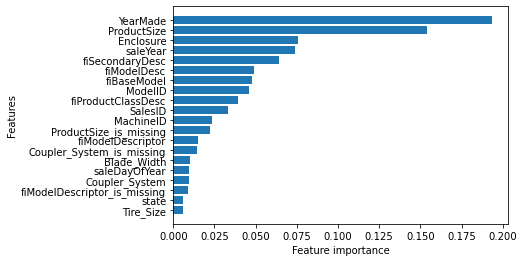

In [40]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({'features':columns,
                        'feature_importances':importances})
          .sort_values('feature_importances', ascending=False)
    .reset_index(drop=True))
    fig, ax = plt.subplots()
    ax.barh(df.features[:n], df.feature_importances[:n])
    ax.set_ylabel('Features')
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()
    
plot_features(X_train.columns, ideal_model.feature_importances_)

**Created by Amir Andikfar - Github.com/AmirAndikfar**